# Fit energies

In [ ]:
from rascal.representations import SphericalInvariants

soap_params = {
# 'species': ["H", "C", "O", "N", "Si"],
# 'periodic': True,
'interaction_cutoff': 3.5, #5
'gaussian_sigma_constant': 0.3,
'max_radial': 4, #5
'max_angular': 4,#5
'cutoff_smooth_width': 0.1,
# 'average': "off",
# 'crossover': True,
# 'dtype': "float64",
# 'n_jobs': 10,
# 'sparse': False,
# 'positions': [7, 11, 15] # ignored
}

In [ ]:
from ase import io

traj_295 = io.read("/data1/simulations/datasets/rotors/high_temp_ML_training_data/results_triasine_ML_2000/struct_295_295K/md_trajectory.traj", index=":")
# traj_355 = io.read("/data1/simulations/datasets/rotors/high_temp_ML_training_data/results_triasine_ML_2000/struct_355_355K/md_trajectory.traj", index=":")

# traj_295_2000K = io.read("/data1/simulations/datasets/rotors/high_temp_ML_training_data/results_triasine_ML_2000/struct_295_2000K/md_trajectory.traj", index=":")
# traj_355_2000K = io.read("/data1/simulations/datasets/rotors/high_temp_ML_training_data/results_triasine_ML_2000/struct_355_2000K/md_trajectory.traj", index=":")
# traj_295_2000K_forced = io.read("/data1/simulations/datasets/rotors/high_temp_ML_training_data/results_triasine_ML_2000/struct_295_2000K_0075force/md_trajectory.traj", index=":")
# traj_355_2000K_forced = io.read("/data1/simulations/datasets/rotors/high_temp_ML_training_data/results_triasine_ML_2000/struct_355_2000K_0075force/md_trajectory.traj", index=":")

traj = traj_295[1000:2000]

In [ ]:
energies = [s.get_potential_energy() for s in traj]

In [ ]:
import matplotlib.pyplot as plt

plt.plot(energies)
plt.show()


In [ ]:
import math
from tqdm import tqdm

def prepare_batches(
        # self, 
        traj, 
        forces,
        energies, 
        frames_per_batch=10):
        
        n_frames = len(traj)
        n_batches = math.ceil(n_frames/frames_per_batch)

        print(f"Total number of frames is {n_frames}")
        print(f"Total number of batches is {n_batches}")

        batches = []
        for i in range(n_batches):
            batch = {}
            batch["traj"] = traj[i*frames_per_batch:(i+1)*frames_per_batch]
        #     batch["forces"] = forces[i*frames_per_batch:(i+1)*frames_per_batch]
            batch["energies"] = energies[i*frames_per_batch:(i+1)*frames_per_batch]
            batches.append(batch)

        return batches



# species= soap_params['species']
# periodic= soap_params['periodic']
interaction_cutoff = soap_params['interaction_cutoff']
gaussian_sigma_constant= soap_params['gaussian_sigma_constant']
max_radial= soap_params['max_radial']
max_angular= soap_params['max_angular']
cutoff_smooth_width = soap_params['cutoff_smooth_width']
# average= soap_params['average']
# crossover= soap_params['crossover']
# dtype= soap_params['dtype']
# sparse= soap_params['sparse']
# positions = soap_params['positions']

hypers = dict(soap_type="PowerSpectrum",
        interaction_cutoff=interaction_cutoff,
        max_radial=max_radial,
        max_angular=max_angular,
        gaussian_sigma_constant=gaussian_sigma_constant,
        gaussian_sigma_type="Constant",
        cutoff_function_type="RadialScaling",
        cutoff_smooth_width=cutoff_smooth_width, # 0.1 is way better than 0.5
        cutoff_function_parameters=
                dict(
                        rate=1,
                        scale=3.5,
                        exponent=4
                        ),
        radial_basis="GTO",
        normalize=False, # setting False makes model untrainable
        #   optimization=
        #         dict(
        #                 Spline=dict(
        #                    accuracy=1.0e-05
        #                 )
        #             ),
        compute_gradients=True,
        expansion_by_species_method='structure wise'
        )

for f in traj:
        f.wrap(eps=1e-18)

n_atoms = len(traj[0])

frames_batches = prepare_batches(traj, [0]*len(traj), energies, frames_per_batch=1)



print(f"Total length of traj is {len(traj)}")
print(f"Total number of batches {len(frames_batches)}")       
print("Calculating invariants on trajectory with librascal...")

soap = SphericalInvariants(**hypers)

X_np_batched = []
E_np_batched = []

# DX_np_batched = [[] * len(frames_batches) for i in range(n_atomic_groups)]  
# F_np_batched = [[] * len(frames_batches) for i in range(n_atomic_groups)]
# grad_info_sub_batched = [[] * len(frames_batches) for i in range(n_atomic_groups)]

for ind_b, batch in enumerate(tqdm(frames_batches)):
        traj_b = batch['traj']
        # forces_b = batch['forces']
        energies_b = batch['energies']

        managers = soap.transform(traj_b)
        soap_array = managers.get_features(soap)
        X_np_batched.append(soap_array)
        E_np_batched.append(energies_b)

In [192]:
indices_non_H = []

for ind,s in enumerate(traj[0].get_chemical_symbols()):
        # print(s)
        if s != "H":
                indices_non_H.append(ind)

In [300]:
import numpy as np

X_np_batched = np.array(X_np_batched)
E_np_batched = np.array(E_np_batched).flatten()

E_np_batched_no_mean = E_np_batched - np.mean(E_np_batched)

In [302]:
import torch

X_np_batched_stacked = X_np_batched.reshape(-1, X_np_batched.shape[-1]*X_np_batched.shape[-2])

train_X = torch.tensor(X_np_batched)
# train_X = train_X.sum(axis=1)
train_Y = torch.tensor(E_np_batched_no_mean)



test_X = train_X[0::100]
test_Y = train_Y[0::100]

train_X = train_X[0::25]
train_Y = train_Y[0::25]

print(train_X.shape)

torch.Size([40, 528, 1200])


In [303]:
test_X.shape

torch.Size([10, 528, 1200])

In [416]:
import torch
import gpytorch
import numpy as np

from gpytorch.kernels import (
    RBFKernel,
    ScaleKernel,
    LinearKernel,
    AdditiveKernel,
    MultitaskKernel,
    PolynomialKernel,
)
from gpytorch.means import ZeroMean, ConstantMean

from gpytorch.models import ExactGP

class ExactGPModelEnergies(ExactGP):
    def __init__(self, train_X, train_Y, likelihood):
        super().__init__(
            train_X, train_Y, likelihood
        )  # the old-style super(ExactGPModel, self) was causing error!
        self.mean_module = ConstantMean()

        self.soap_dim = train_X.shape[-1]
        self.covar_module = ScaleKernel(RBFKernel(ard_num_dims=self.soap_dim))#LinearKernel()

    def forward(self, X):
        x = X
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)





class ExactGPModelEnergiesMulti(ExactGP):
    def __init__(self, train_X, train_Y, likelihood):
        super().__init__(
            train_X, train_Y, likelihood
        )  # the old-style super(ExactGPModel, self) was causing error!

        # for i in range(528):
        #     means.append(ConstantMean())

        # alphas = torch.zeros(528)

        # self.mean_module = [ZeroMean() for i in range(528)]
        # self.covar_module = [ScaleKernel(RBFKernel(ard_num_dims=train_X.shape[-1])) for i in range(528)]

        self.mean_module = ConstantMean()

        self.soap_dim = train_X.shape[-1]
        self.covar_module = ScaleKernel(RBFKernel(ard_num_dims=self.soap_dim))#LinearKernel()

    def forward(self, X):
        x = X
        # print(x.shape)
        # mean_x = self.mean_module(x)
        # covar_x = self.covar_module(x)

        x = X
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

        # means = [self.mean_module[i](x[:,i]) for i in range(528)]
        # covars = [self.covar_module[i](x[:,i]) for i in range(528)]

        # print(covars)
        # self.means = means
        # self.covars = covars

        # covar_x = torch.sum(covars, dim=0)
        # mean_x = torch.sum(means, dim=0)
        # self.covar_test = covars[0]
        

        # covar_sum = covars[0]
        # mean_sum = means[0]
        # for i in range(1,528):
        #         covar_sum += covars[i]
        #         mean_sum += means[i]

        # # print("Summation done!")
        # mean_x = mean_sum
        # covar_x = covar_sum


        # return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [477]:
C = torch.zeros((40,40))

i = 0
j = 1
covar_ij = model.covar_module(train_X[i,:,:], train_X[j,:,:]).evaluate().sum()

for i in range(40):
    for j in range(40):
        covar_ij = model.covar_module(train_X[i,:,:], train_X[j,:,:]).evaluate().sum()
        C[i,j] = covar_ij
        # print(f"{i} {j} {covar_ij}")

In [483]:
for i in range(40):
        print(C[0,i])

tensor(193238.3125, grad_fn=<SelectBackward0>)
tensor(193238.3125, grad_fn=<SelectBackward0>)
tensor(193238.3125, grad_fn=<SelectBackward0>)
tensor(193238.3125, grad_fn=<SelectBackward0>)
tensor(193238.3125, grad_fn=<SelectBackward0>)
tensor(193238.3125, grad_fn=<SelectBackward0>)
tensor(193238.3125, grad_fn=<SelectBackward0>)
tensor(193238.3125, grad_fn=<SelectBackward0>)
tensor(193238.3125, grad_fn=<SelectBackward0>)
tensor(193238.3125, grad_fn=<SelectBackward0>)
tensor(193238.3125, grad_fn=<SelectBackward0>)
tensor(193238.3125, grad_fn=<SelectBackward0>)
tensor(193238.3125, grad_fn=<SelectBackward0>)
tensor(193238.3125, grad_fn=<SelectBackward0>)
tensor(193238.3125, grad_fn=<SelectBackward0>)
tensor(193238.3125, grad_fn=<SelectBackward0>)
tensor(193238.3125, grad_fn=<SelectBackward0>)
tensor(193238.3125, grad_fn=<SelectBackward0>)
tensor(193238.3125, grad_fn=<SelectBackward0>)
tensor(193238.3125, grad_fn=<SelectBackward0>)
tensor(193238.3125, grad_fn=<SelectBackward0>)
tensor(193238

In [482]:
covar_ij

tensor(193238.3095, dtype=torch.float64, grad_fn=<SumBackward0>)

In [385]:
# this is for running the notebook in our testing framework
import os




# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
# model = ExactGPModelEnergies(train_X, train_Y, likelihood)
model = ExactGPModelEnergiesMulti(train_X, train_Y, likelihood)


training_iter = 10


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

print("Training...")
# initial_loss = -mll(model(train_X), train_Y).item()
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    print("grad zeroed")
    # Output from model
    output = model(train_X)
    print("Output calculated")
    print(output)
    # Calc loss and backprop gradients
    loss = -mll(output, train_Y)
    print("Loss calculated")

    loss.backward()
    # print(loss)
    # print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
    #     i + 1, training_iter, loss.item(),
    #     model.covar_module.base_kernel.lengthscale.item(),
    #     model.likelihood.noise.item()
    # ))
    print(loss)
    optimizer.step()

print("Initial loss: ", initial_loss)
print("Final loss: ", loss)


Training...
grad zeroed
Output calculated
MultivariateNormal(loc: torch.Size([40, 528]))


RuntimeError: The size of tensor a (40) must match the size of tensor b (528) at non-singleton dimension 1

In [299]:
test_x.shape

torch.Size([1000, 528, 1200])

torch.Size([10, 528, 1200])
Summation done!


tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=torch.float64)

In [312]:

pred = likelihood(model.forward(test_X)).mean
print(pred)

torch.Size([10, 528, 1200])
Summation done!
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=torch.float64)


In [297]:
pred.mean

tensor([], dtype=torch.float64, grad_fn=<ViewBackward0>)

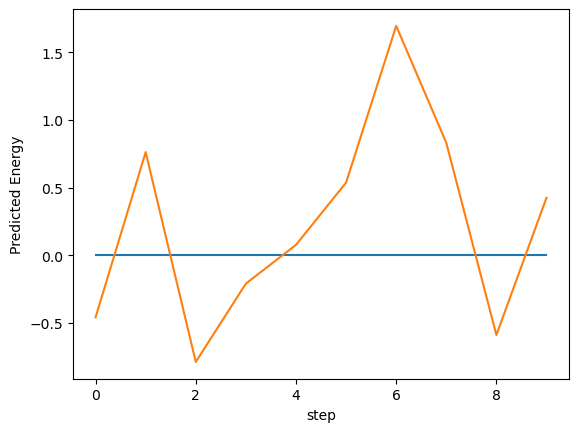

In [318]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

test_x = test_X

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
#     test_x = torch.linspace(0, 1, 51)
    observed_pred = likelihood(model.forward(test_x))


import matplotlib.pyplot as plt

plt.plot(observed_pred.mean)
plt.plot(test_Y)
plt.xlabel('step')
plt.ylabel('Predicted Energy')
plt.show()

# error = observed_pred.mean() - np.array(test_Y)